<font size="+3"><strong>JNB3 Predicting Price with Neighborhood</strong></font>

In [6]:
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline

In the last notebook, I created a model that used location — represented by latitude and longitude — to predict price. Here, I am going to use a different representation for location: neighborhood.

# Prepare Data

## Import

I modified the `wrangle` function to create a new feature `"neighborhood"`. You can find the neighborhood for each property in the `"place_with_parent_names"` column. For example, a property with the place name `"|Argentina|Capital Federal|Palermo|"` is located in the neighborhood is `"Palermo"`. Also, the function should drop the `"place_with_parent_names"` column.

In [7]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
    
    # Extracting the neighborhood column
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    
    # Drop the "place_with_parent_names" column
    df.drop(columns=["place_with_parent_names"], inplace=True)
    
    return df

In the last lesson, I used the `wrangle` function to import two CSV files as DataFrames. But what if I had hundreds of CSV files to import? Wrangling them one-by-one wouldn't be an option. So I'll start with a technique for reading several CSV files into a single DataFrame. 

The first step is to gather the names of all the files we want to import. We can do this using pattern matching.

Use glob to create a list that contains the filenames for all the Buenos Aires real estate CSV files in the data directory. Assign this list to the variable name files.

In [15]:
files = glob("data/argentina_realestate_*.csv")
files

['data/argentina_realestate_3.csv',
 'data/argentina_realestate_2.csv',
 'data/argentina_realestate_1.csv',
 'data/argentina_realestate_5.csv',
 'data/argentina_realestate_4.csv']

I used the wrangle function in a for loop to create a list named frames. The list should then clean DataFrames created from the CSV filenames you collected in files.

In [16]:
frames = [wrangle(file) for file in files]
frames[0].head()

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
7,sell,apartment,120000.0,USD,1819488.00,120000.0,NaN,55.0,NaN,2181.818182,NaN,2.0,NaN,http://villa-general-mitre.properati.com.ar/xx...,-34.616004,-58.470506,Villa General Mitre
20,sell,apartment,89000.0,USD,1349453.60,89000.0,NaN,37.0,NaN,2405.405405,7.0,2.0,NaN,http://palermo.properati.com.ar/ya5i_venta_dep...,-34.584712,-58.444927,Palermo
21,sell,apartment,183495.0,USD,2782224.58,183495.0,92.0,57.0,1994.51087,3219.210526,NaN,2.0,NaN,http://saavedra.properati.com.ar/12izq_venta_d...,-34.554652,-58.493644,Saavedra
41,sell,apartment,95000.0,USD,1440428.00,95000.0,53.0,47.0,1792.45283,2021.276596,NaN,2.0,NaN,http://villa-del-parque.properati.com.ar/wy0n_...,-34.610581,-58.479625,Villa del Parque
43,sell,apartment,95000.0,USD,1440428.00,95000.0,0.0,35.0,NaN,2714.285714,NaN,1.0,NaN,http://belgrano.properati.com.ar/xw9a_venta_de...,-34.558227,-58.458357,Belgrano


I will use pd.concat to concatenate the items in frames into a single DataFrame df. Make sure you set the ignore_index argument to True.

In [18]:
df = pd.concat(frames, ignore_index=True)
df.head()

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
0,sell,apartment,120000.0,USD,1819488.00,120000.0,NaN,55.0,NaN,2181.818182,NaN,2.0,NaN,http://villa-general-mitre.properati.com.ar/xx...,-34.616004,-58.470506,Villa General Mitre
1,sell,apartment,89000.0,USD,1349453.60,89000.0,NaN,37.0,NaN,2405.405405,7.0,2.0,NaN,http://palermo.properati.com.ar/ya5i_venta_dep...,-34.584712,-58.444927,Palermo
2,sell,apartment,183495.0,USD,2782224.58,183495.0,92.0,57.0,1994.51087,3219.210526,NaN,2.0,NaN,http://saavedra.properati.com.ar/12izq_venta_d...,-34.554652,-58.493644,Saavedra
3,sell,apartment,95000.0,USD,1440428.00,95000.0,53.0,47.0,1792.45283,2021.276596,NaN,2.0,NaN,http://villa-del-parque.properati.com.ar/wy0n_...,-34.610581,-58.479625,Villa del Parque
4,sell,apartment,95000.0,USD,1440428.00,95000.0,0.0,35.0,NaN,2714.285714,NaN,1.0,NaN,http://belgrano.properati.com.ar/xw9a_venta_de...,-34.558227,-58.458357,Belgrano


## Explore

I did explore the data as I cleaned it and came up with the wrangle function.

## Split

In [20]:
features = ["neighborhood"]
target = "price_aprox_usd"
X_train = df[features]
y_train = df[target]
print(X_train.shape)
y_train.shape

(6582, 1)


(6582,)

## Build Model

### Baseline

In [23]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean for i in y_train]

print("Mean apt price:", y_mean.round(2))

print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline).round(2))

Mean apt price: 132383.84
Baseline MAE: 44860.11


Now I will use the `OneHotEncoder` from the sklearn.preprocessing library to encode the non-numerical data.

In [32]:
ohe = OneHotEncoder(sparse_output=False)

ohe.fit(X_train)

# Retrieve the encoded feature names
feature_names = ohe.get_feature_names_out(X_train.columns)

XT_train = pd.DataFrame(ohe.transform(X_train), columns=feature_names)
print(XT_train.shape)
XT_train.head()

(6582, 57)


,neighborhood_,neighborhood_Abasto,neighborhood_Agronomía,neighborhood_Almagro,neighborhood_Balvanera,neighborhood_Barracas,neighborhood_Barrio Norte,neighborhood_Belgrano,neighborhood_Boca,neighborhood_Boedo,...,neighborhood_Villa General Mitre,neighborhood_Villa Lugano,neighborhood_Villa Luro,neighborhood_Villa Ortuzar,neighborhood_Villa Pueyrredón,neighborhood_Villa Real,neighborhood_Villa Santa Rita,neighborhood_Villa Soldati,neighborhood_Villa Urquiza,neighborhood_Villa del Parque
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


make a pipeline

In [33]:
model = make_pipeline(
    OneHotEncoder(sparse_output=False),
    Ridge()
)

model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(sparse_output=False)),
                ('ridge', Ridge())])

## Evaluate

Regardless of how you build your model, the evaluation step stays the same. Let's see how our model performs with the training set.

In [34]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 39350.22


# Communicate Results

If I write out the equation for the model, it'll be too big to fit on the screen. That's because, when I used the `OneHotEncoder` to encode the neighborhood data, I created a much wider DataFrame, and each column/feature has it's own coefficient in the model's equation.

<center><img src="images/img-6.png" alt="Equation: y = β0 + β1 x1 + β2 x2 + ... + β59 x59 + β60 x60 " style="width: 800px;"/></center>

This is important to keep in mind for two reasons. First, it means that this is a **high-dimensional** model. Instead of a 2D or 3D plot, we'd need a 58-dimensional plot to represent it, which is impossible! Second, it means that we'll need to extract and represent the information for our equation a little differently than before. Let's start by getting our intercept and coefficient.

In [48]:
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
print("intercept:", round(intercept, 2))
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

intercept: 118524.65
coefficients len: 57
[-19370.74349751   4330.54631771   -772.70368229   2903.33556626
 -11172.55279922]


Extract the feature names from the OneHotEncoder in your model

In [41]:
feature_names = model.named_steps["onehotencoder"].get_feature_names_out()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 57
['neighborhood_' 'neighborhood_Abasto' 'neighborhood_Agronomía'
 'neighborhood_Almagro' 'neighborhood_Balvanera']


We have coefficients and feature names so we shall use Series to put them together.

In [44]:
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp.head()

neighborhood_            -19370.743498
neighborhood_Abasto        4330.546318
neighborhood_Agronomía     -772.703682
neighborhood_Almagro       2903.335566
neighborhood_Balvanera   -11172.552799
dtype: float64

For visibility into what is going on I will print out the equation for our modle

In [45]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = 118524.65
+ (-19370.74 * neighborhood_)
+ (4330.55 * neighborhood_Abasto)
+ (-772.7 * neighborhood_Agronomía)
+ (2903.34 * neighborhood_Almagro)
+ (-11172.55 * neighborhood_Balvanera)
+ (-4618.66 * neighborhood_Barracas)
+ (55590.93 * neighborhood_Barrio Norte)
+ (46954.21 * neighborhood_Belgrano)
+ (-28353.36 * neighborhood_Boca)
+ (-6837.4 * neighborhood_Boedo)
+ (9252.89 * neighborhood_Caballito)
+ (-22012.32 * neighborhood_Catalinas)
+ (-7905.29 * neighborhood_Centro / Microcentro)
+ (-2898.96 * neighborhood_Chacarita)
+ (12223.11 * neighborhood_Coghlan)
+ (38436.33 * neighborhood_Colegiales)
+ (-7974.66 * neighborhood_Congreso)
+ (-41748.73 * neighborhood_Constitución)
+ (-8662.28 * neighborhood_Flores)
+ (-14088.02 * neighborhood_Floresta)
+ (72270.21 * neighborhood_Las Cañitas)
+ (-13729.1 * neighborhood_Liniers)
+ (-21078.78 * neighborhood_Mataderos)
+ (-20292.6 * neighborhood_Monserrat)
+ (-3427.44 * neighborhood_Monte Castro)
+ (42831.32 * neighborhood_Nuñez)
+ (-3230

A horizontal bar chart that shows the top 15 coefficients for your model, based on their absolute value.

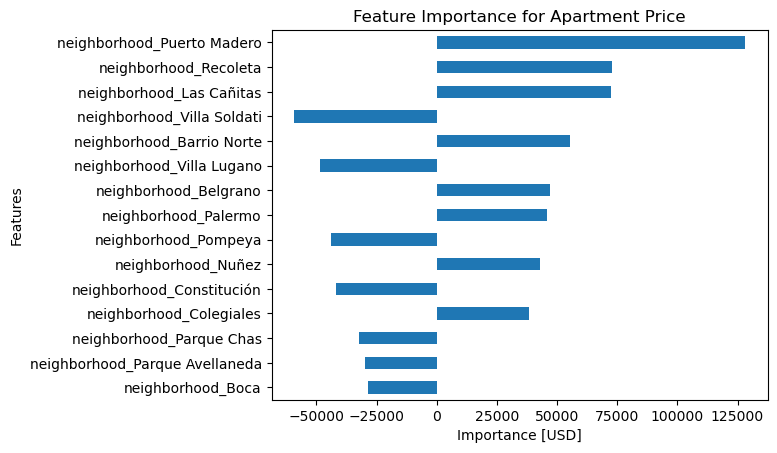

In [47]:
feat_imp.sort_values(key=abs).tail(15).plot(kind="barh")
plt.xlabel("Importance [USD]")
plt.ylabel("Features")
plt.title("Feature Importance for Apartment Price");